In [2]:
import os
import json
from pathlib import Path
from PIL import Image

NB_DIR = Path().resolve()
ROOT = NB_DIR.parent
print(ROOT)

LABELME_DIR = Path(f"{ROOT}/data/ball_detection/ball_img_json")   # folder containing .json and images
YOLO_DIR    = Path(f"{ROOT}/data/ball_detection/ball_yolo_labels")          # output dataset folder

YOLO_DIR.mkdir(parents=True, exist_ok=True)
print("Found JSON files:", len(list(LABELME_DIR.glob("*.json"))))

C:\Users\jleto\Projects\rev-vision
Found JSON files: 2


In [3]:
import random

# Collect all LabelMe JSONs
json_files = sorted(LABELME_DIR.glob("*.json"))
assert len(json_files) > 0, "No LabelMe JSON files found"

# Train/val split (80/20)
random.seed(42)
random.shuffle(json_files)

split_idx = int(0.8 * len(json_files))
train_files = json_files[:split_idx]
val_files   = json_files[split_idx:]

# Create YOLO folder structure
for split in ["train", "val"]:
    (YOLO_DIR / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / "labels" / split).mkdir(parents=True, exist_ok=True)

print(f"Total images: {len(json_files)}")
print(f"Train: {len(train_files)}")
print(f"Val:   {len(val_files)}")

Total images: 2
Train: 1
Val:   1


In [3]:
from PIL import Image
import shutil

CLASS_NAME = "lane_ball"
CLASS_ID = 0  # single class

def labelme_json_to_yolo(json_path, split):
    with open(json_path, "r") as f:
        data = json.load(f)

    # Load image to get width/height
    img_path = LABELME_DIR / data["imagePath"]
    img = Image.open(img_path)
    W, H = img.size

    # Expect exactly one rectangle (your ball)
    shapes = data["shapes"]
    rects = [s for s in shapes if s["shape_type"] == "rectangle"]
    if len(rects) != 1:
        return  # skip malformed labels

    (x1, y1), (x2, y2) = rects[0]["points"]

    # YOLO format: class cx cy w h (all normalized)
    cx = ((x1 + x2) / 2) / W
    cy = ((y1 + y2) / 2) / H
    bw = abs(x2 - x1) / W
    bh = abs(y2 - y1) / H

    yolo_line = f"{CLASS_ID} {cx} {cy} {bw} {bh}\n"

    # Write label
    label_out = YOLO_DIR / "labels" / split / (json_path.stem + ".txt")
    with open(label_out, "w") as f:
        f.write(yolo_line)

    # Copy image
    img_out = YOLO_DIR / "images" / split / img_path.name
    shutil.copy(img_path, img_out)


# Run conversion
for jp in train_files:
    labelme_json_to_yolo(jp, "train")

for jp in val_files:
    labelme_json_to_yolo(jp, "val")

print("Conversion complete.")

Conversion complete.


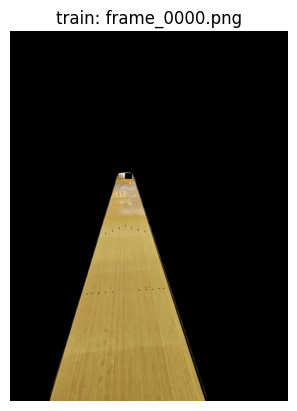

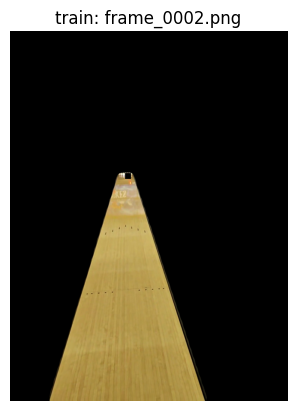

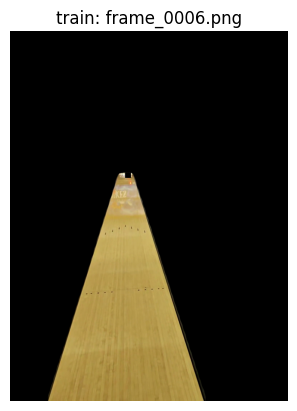

In [12]:
import matplotlib.pyplot as plt

def show_sample(split="train", n=3):
    img_dir = YOLO_DIR / "images" / split
    lbl_dir = YOLO_DIR / "labels" / split

    imgs = list(img_dir.glob("*"))[:n]
    for img_path in imgs:
        lbl_path = lbl_dir / (img_path.stem + ".txt")
        if not lbl_path.exists():
            continue

        img = Image.open(img_path)
        W, H = img.size

        with open(lbl_path) as f:
            _, cx, cy, bw, bh = map(float, f.readline().split())

        x1 = (cx - bw/2) * W
        y1 = (cy - bh/2) * H
        x2 = (cx + bw/2) * W
        y2 = (cy + bh/2) * H

        plt.imshow(img)
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2)
        )
        plt.title(f"{split}: {img_path.name}")
        plt.axis("off")
        plt.show()

show_sample("train", n=3)

In [5]:
DATA_YAML = YOLO_DIR / "lane_ball.yaml"

yaml_text = f"""
path: {YOLO_DIR.resolve()}
train: images/train
val: images/val

names:
  0: lane_ball
"""

with open(DATA_YAML, "w") as f:
    f.write(yaml_text.strip())

print("Dataset YAML written to:", DATA_YAML)

Dataset YAML written to: C:\Users\jleto\Projects\rev-vision\data\ball_detection\ball_yolo_labels\lane_ball.yaml


In [6]:
from ultralytics import YOLO
from pathlib import Path

# model = YOLO("yolov8n.pt")  # Load a small pretrained model

ROOT = Path.cwd().parent
model = YOLO(ROOT / "data/weights/best_ball.pt") # Load a previously trained model

# Train
model.train(
    data=str(DATA_YAML),
    epochs=30,
    imgsz=640,
    batch=8,
    name="lane_ball_yolo_v3",
)

Ultralytics 8.3.241  Python-3.12.10 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jleto\Projects\rev-vision\data\ball_detection\ball_yolo_labels\lane_ball.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=c:\Users\jleto\Projects\rev-vision\data\weights\best_ball.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=lane_ba

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B4304025D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480


0: 640x480 (no detections), 50.8ms
Speed: 2.1ms preprocess, 50.8ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 480)


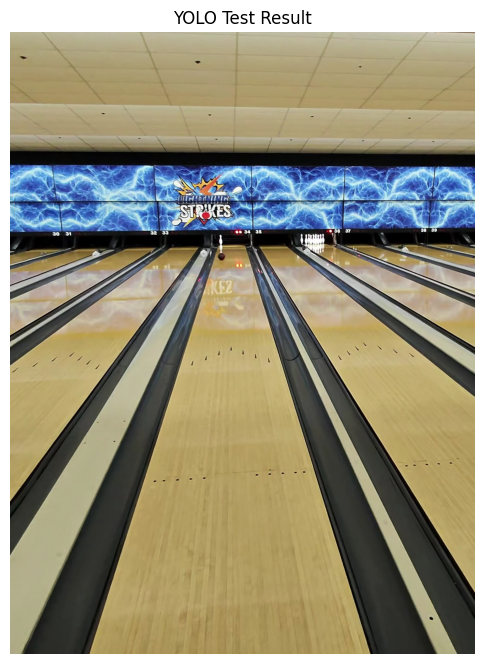

tensor([], size=(0, 4))


In [12]:
from ultralytics import YOLO
import cv2
import glob
import random
import matplotlib.pyplot as plt

model = YOLO(f"{ROOT}/data/weights/best_ball.pt")

# Load a test image
img_path = random.choice(glob.glob(f"{ROOT}/data/raw_frames/images/*"))
img = cv2.imread(img_path)
assert img is not None

# Run inference
results = model(img, conf=0.4, imgsz=640)

# Draw detections
annotated = results[0].plot()

# YOLO returns BGR image, convert to RGB
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 10))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title("YOLO Test Result")
plt.show()

# Print boxes (sanity)
print(results[0].boxes.xyxy if results[0].boxes is not None else "No detections")